**Name: Osama Sidahmed**

**Capstone project: Detecting and Predicting Seizure Onset**

**Date Submitted: 11 Apr 2021**

**Notebook: 3_Modelling_Detection**

**Notebook order: 3/4**

**Preceding notebooks: `1_Initial_EDA` and `2_Features_Extraction`**

**Following notebooks: `4_Modelling_Prediction`**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modelling</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

#  Introduction

So far features have been extracted to the frequency domain and initial modeling for the detection problem has been conducted. This notebook takes the detection problem only in an attempt to optimize a working model using different Neural networks hyper parameters. Dataset_2 is the dataset used on this notebook and on the next notebook.

As an approach as to how to classify the detection problem, everything that happens before the seizure has started or after the seizure has finished is considered as class 0 while class 1 is represented by the seizure event.

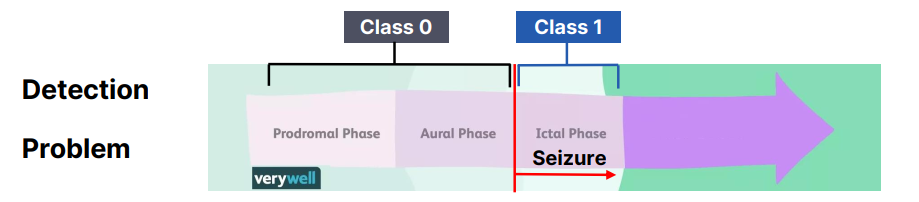

The models have been optimized manually using a combination of few hyper parameters, changing one or two at time. The hyper-parameters controlled are:
- The number of hidden layers.
- The number of neurons in the hidden layers.
- Regularization value.
- Hidden layers activation methods.
- The number of epochs.

The validation set was passed when the models were fit to assess the model performance during fitting.

In addition to the accuracy metric, the Recall, Precision and confusion matrix metrics where being monitored during fitting to assess the model performance. This were very helpful to assess the best model as we will see. It was decided to optimize the models manually to have a direct control to stop the model based on the train and val metrics performance.

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# MNE is a library used for brain data manipulation -
# Open-source Python package for exploring, visualizing, and analyzing human neurophysiological data
# https://mne.tools/stable/index.html
import mne

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Helper function to notify me once a long code block execution is finished - may only work in Windows
import winsound
'''
Helper function to peep once called
'''
def peep_me():
    winsound.Beep(frequency=2500, duration=500)

#  Modelling

First, read the csv file containing dataset_2 frequency domain features for all patients as has been saved on the previous notebook.

In [4]:
# Read csv file containig the data
path = 'data/dataset_2/combined_files'

df_seizure_w = pd.read_csv(
    path + '/' + 'seizure_w_ds2_3s_280321_full.csv')

In [5]:
df_seizure_w.head(3)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1141,1142,1143,1144,1145,1146,1147,1148,1149,target
0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,1,7.069850e-14,7.077120e-14,7.089218e-14,7.106119e-14,7.127784e-14,7.154167e-14,7.185210e-14,7.220844e-14,7.260991e-14,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,2,5.036653e-14,5.041897e-14,5.050624e-14,5.062815e-14,5.078444e-14,5.097476e-14,5.119871e-14,5.145580e-14,5.174547e-14,...,4.120198e-14,4.158553e-14,4.198528e-14,4.240036e-14,4.282981e-14,4.327270e-14,4.372803e-14,4.419478e-14,4.467191e-14,0.0


Delete any and all unnamed columns.

In [6]:
df_seizure_w = df_seizure_w.loc[:, ~df_seizure_w.columns.str.contains('^Unnamed')]
df_seizure_w.head(1)

,0,1,2,3,4,5,6,7,8,9,...,1141,1142,1143,1144,1145,1146,1147,1148,1149,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Explore the row where there is seizure, the target == 1.

In [37]:
df_seizure_w[df_seizure_w['target'] == 1].head(10)

,0,1,2,3,4,5,6,7,8,9,...,1141,1142,1143,1144,1145,1146,1147,1148,1149,target
998,1.808559e-13,1.810355e-13,1.813343e-13,1.817518e-13,1.822870e-13,1.829388e-13,1.837057e-13,1.845861e-13,1.855781e-13,1.866796e-13,...,4.661637e-14,4.709097e-14,4.758592e-14,4.810014e-14,4.863254e-14,4.918198e-14,4.974727e-14,5.032721e-14,5.092056e-14,1.0
999,1.567787e-12,1.569824e-12,1.573216e-12,1.577958e-12,1.584041e-12,1.591456e-12,1.600193e-12,1.610236e-12,1.621570e-12,1.634178e-12,...,7.664565e-13,7.750498e-13,7.840308e-13,7.933832e-13,8.030901e-13,8.131340e-13,8.234968e-13,8.341601e-13,8.451048e-13,1.0
1000,8.537416e-13,8.546877e-13,8.562623e-13,8.584625e-13,8.612838e-13,8.647206e-13,8.687661e-13,8.734123e-13,8.786500e-13,8.844688e-13,...,2.096769e-12,2.124423e-12,2.153370e-12,2.183567e-12,2.214966e-12,2.247519e-12,2.281176e-12,2.315885e-12,2.351593e-12,1.0
1001,3.729182e-12,3.733386e-12,3.740385e-12,3.750167e-12,3.762713e-12,3.778004e-12,3.796012e-12,3.816705e-12,3.840049e-12,3.866002e-12,...,2.302500e-12,2.332967e-12,2.364873e-12,2.398171e-12,2.432811e-12,2.468743e-12,2.505912e-12,2.544265e-12,2.583745e-12,1.0
1002,4.341605e-12,4.346831e-12,4.355532e-12,4.367692e-12,4.383289e-12,4.402297e-12,4.424681e-12,4.450404e-12,4.479420e-12,4.511678e-12,...,4.960362e-12,5.019396e-12,5.081211e-12,5.145715e-12,5.212810e-12,5.282396e-12,5.354369e-12,5.428621e-12,5.505043e-12,1.0
1003,5.833812e-12,5.840017e-12,5.850346e-12,5.864779e-12,5.883289e-12,5.905841e-12,5.932393e-12,5.962895e-12,5.997289e-12,6.035510e-12,...,5.669317e-12,5.735047e-12,5.803860e-12,5.875649e-12,5.950304e-12,6.027709e-12,6.107747e-12,6.190295e-12,6.275230e-12,1.0
1004,4.400968e-12,4.406364e-12,4.415345e-12,4.427896e-12,4.443995e-12,4.463612e-12,4.486713e-12,4.513257e-12,4.543196e-12,4.576476e-12,...,5.857533e-12,5.934041e-12,6.014141e-12,6.097711e-12,6.184624e-12,6.274745e-12,6.367939e-12,6.464065e-12,6.562977e-12,1.0
1005,2.365802e-12,2.368788e-12,2.373759e-12,2.380705e-12,2.389615e-12,2.400473e-12,2.413259e-12,2.427951e-12,2.444523e-12,2.462945e-12,...,4.564547e-12,4.638476e-12,4.715973e-12,4.796935e-12,4.881254e-12,4.968816e-12,5.059507e-12,5.153206e-12,5.249791e-12,1.0
1006,7.129062e-13,7.136922e-13,7.150005e-13,7.168285e-13,7.191726e-13,7.220283e-13,7.253899e-13,7.292509e-13,7.336037e-13,7.384398e-13,...,1.109755e-11,1.123391e-11,1.137671e-11,1.152573e-11,1.168077e-11,1.184158e-11,1.200793e-11,1.217958e-11,1.235627e-11,1.0
1007,1.709071e-12,1.710863e-12,1.713846e-12,1.718014e-12,1.723360e-12,1.729871e-12,1.737537e-12,1.746342e-12,1.756268e-12,1.767297e-12,...,5.859772e-12,5.944550e-12,6.033394e-12,6.126183e-12,6.222787e-12,6.323073e-12,6.426905e-12,6.534141e-12,6.644636e-12,1.0


Check the target distribution and imbalance, ~ 99% :~ 1%.

In [7]:
df_seizure_w['target'].value_counts()

0.0    96278
1.0     1034
Name: target, dtype: int64

97312 rows, 1150 features + the target column.

In [8]:
df_seizure_w.shape

(97312, 1151)

On the following code block, the X and y are separated into three blocks, train, validation and test. Both the train and validation are up-sampled 100% but not the test data. Then the train, val and test sets are scaled and their dimensionality is reduced form 1150 to 11 using PCA @97%.

In [9]:
# read file

# path = 'data/dataset_2'
# combined_files_path = 'combined_files'

# print(f'Reading file.......................................', end='\r')
# df_seizure_w = pd.read_csv(path + '/' + combined_files_path + '/' + 'seizure_w_ds2_3s_280321_full.csv')


# Separate x and y
X = df_seizure_w.drop('target', axis=1)
y = df_seizure_w['target']


# Split into train/Val and test before SMOTE
from sklearn.model_selection import train_test_split

print(f'Splitting data into train/Val and test before SMOTE..........', end='\r')
X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# Split into train and val before SMOTE
print(f'Splitting data into train and val before SMOTE..........', end='\r')
X_train, X_val, y_train, y_val= train_test_split(X_remain, y_remain, test_size=0.2, stratify=y_remain, random_state=1)

import imblearn
from imblearn.over_sampling import SMOTE

print(f'SMOTE operation ...................................................', end='\r')
# 100% SMOTE strategy
strategy = {0.0:y_train.value_counts()[0], 1.0:(y_train.value_counts()[0]).astype(int)}
oversample = SMOTE(sampling_strategy=strategy, random_state = 1)  # 100% oversampling
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

strategy = {0.0:y_val.value_counts()[0], 1.0:(y_val.value_counts()[0]).astype(int)}
oversample = SMOTE(sampling_strategy=strategy, random_state = 1)  # 100% oversampling
X_val_os, y_val_os = oversample.fit_resample(X_val, y_val) #?????????????????????????

# Use standard scaler for the first pass
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

print(f'Scaling patient data..................................', end='\r')
# Scale data - train + test, first fit
standard_scaler.fit(X_train_os)
X_train_os_ss = standard_scaler.transform(X_train_os)
X_val_os_ss = standard_scaler.transform(X_val_os)
X_test_ss = standard_scaler.transform(X_test)

# PCA first to look at the data - reduce dimensions
from sklearn.decomposition import PCA

print(f'PCA operation on data..................................', end='\r')
# Fit and transform
pca = PCA(n_components=X_train_os_ss.shape[1])
pca.fit(X_train_os_ss)  # _ss is scaled data
X_train_os_ss_PCA = pca.transform(X_train_os_ss)
X_val_os_ss_PCA = pca.transform(X_val_os_ss)
X_test_ss_PCA = pca.transform(X_test_ss)

expl_var = pca.explained_variance_ratio_
pca_expl_var = np.cumsum(expl_var)[10]
print(f'pca_expl_var: {pca_expl_var}..............................', end='\r')

# Extract the first 10 dimensions only
# Fit and transform
pca = PCA(n_components=10)
pca.fit(X_train_os_ss) # _ss is scaled data
X_train_os_ss_PCA10 = pca.transform(X_train_os_ss)
X_val_os_ss_PCA10 = pca.transform(X_val_os_ss)
X_test_ss_PCA10 = pca.transform(X_test_ss)

peep_me()

Then the scaler and PCA models are pickled for future use on the software to scale and PCA prediction data before being modelled,

In [ ]:
# Save as PCA and scaler in pickles 050421

In [10]:
# Save as PCA and scaler
import joblib
standard_scaler_file = 'data/joblib/ss_ictal_050421.joblib'
pca_file = 'data/joblib/pca10_ictal_050421.joblib'
joblib.dump(standard_scaler, standard_scaler_file) 
joblib.dump(pca, pca_file) 

['data/joblib/pca10_ictal_050421.joblib']

Model Ictal-1

In [38]:
# Create a new sequential model

METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))  # Set 10% of the nodes to 0.

model.add(layers.Dense(20, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))  # Set 10% of the nodes to 0.

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))  # Set 10% of the nodes to 0.

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [ ]:
epochs=450

In [51]:
# Fit the model
# Cell 22

# Train the model
history = model.fit(X_train_os_ss_PCA10,
                    y_train_os,
                    epochs=450,
                    verbose=1,
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))

peep_me()

Epoch 1/450
3852/3852 [==============================] - 9s 2ms/step - loss: 0.2550 - tp: 56656.0000 - fp: 5624.0000 - tn: 55993.0000 - fn: 4961.0000 - accuracy: 0.9141 - precision: 0.9097 - recall: 0.9195 - auc: 0.9732 - val_loss: 0.4592 - val_tp: 13788.0000 - val_fp: 2488.0000 - val_tn: 12917.0000 - val_fn: 1617.0000 - val_accuracy: 0.8668 - val_precision: 0.8471 - val_recall: 0.8950 - val_auc: 0.9437
Epoch 2/450
3852/3852 [==============================] - 9s 2ms/step - loss: 0.2563 - tp: 56626.0000 - fp: 5704.0000 - tn: 55913.0000 - fn: 4991.0000 - accuracy: 0.9132 - precision: 0.9085 - recall: 0.9190 - auc: 0.9726 - val_loss: 0.4168 - val_tp: 12235.0000 - val_fp: 625.0000 - val_tn: 14780.0000 - val_fn: 3170.0000 - val_accuracy: 0.8768 - val_precision: 0.9514 - val_recall: 0.7942 - val_auc: 0.9571
Epoch 3/450
3852/3852 [==============================] - 9s 2ms/step - loss: 0.2564 - tp: 56626.0000 - fp: 5667.0000 - tn: 55950.0000 - fn: 4991.0000 - accuracy: 0.9135 - precision: 0.909

3852/3852 [==============================] - 6s 2ms/step - loss: 0.2508 - tp: 56922.0000 - fp: 5600.0000 - tn: 56017.0000 - fn: 4695.0000 - accuracy: 0.9165 - precision: 0.9104 - recall: 0.9238 - auc: 0.9742 - val_loss: 0.4383 - val_tp: 13944.0000 - val_fp: 1906.0000 - val_tn: 13499.0000 - val_fn: 1461.0000 - val_accuracy: 0.8907 - val_precision: 0.8797 - val_recall: 0.9052 - val_auc: 0.9581
Epoch 42/450
3852/3852 [==============================] - 6s 2ms/step - loss: 0.2513 - tp: 56946.0000 - fp: 5650.0000 - tn: 55967.0000 - fn: 4671.0000 - accuracy: 0.9162 - precision: 0.9097 - recall: 0.9242 - auc: 0.9743 - val_loss: 0.4677 - val_tp: 12931.0000 - val_fp: 910.0000 - val_tn: 14495.0000 - val_fn: 2474.0000 - val_accuracy: 0.8902 - val_precision: 0.9343 - val_recall: 0.8394 - val_auc: 0.9612
Epoch 43/450
3852/3852 [==============================] - 6s 2ms/step - loss: 0.2511 - tp: 56815.0000 - fp: 5515.0000 - tn: 56102.0000 - fn: 4802.0000 - accuracy: 0.9163 - precision: 0.9115 - recall

3852/3852 [==============================] - 8s 2ms/step - loss: 0.2563 - tp: 56737.0000 - fp: 5775.0000 - tn: 55842.0000 - fn: 4880.0000 - accuracy: 0.9135 - precision: 0.9076 - recall: 0.9208 - auc: 0.9733 - val_loss: 0.4670 - val_tp: 12107.0000 - val_fp: 572.0000 - val_tn: 14833.0000 - val_fn: 3298.0000 - val_accuracy: 0.8744 - val_precision: 0.9549 - val_recall: 0.7859 - val_auc: 0.9598
Epoch 82/450
3852/3852 [==============================] - 7s 2ms/step - loss: 0.2487 - tp: 57008.0000 - fp: 5497.0000 - tn: 56120.0000 - fn: 4609.0000 - accuracy: 0.9180 - precision: 0.9121 - recall: 0.9252 - auc: 0.9752 - val_loss: 0.4027 - val_tp: 13867.0000 - val_fp: 1601.0000 - val_tn: 13804.0000 - val_fn: 1538.0000 - val_accuracy: 0.8981 - val_precision: 0.8965 - val_recall: 0.9002 - val_auc: 0.9586
Epoch 83/450
3852/3852 [==============================] - 7s 2ms/step - loss: 0.2466 - tp: 57053.0000 - fp: 5522.0000 - tn: 56095.0000 - fn: 4564.0000 - accuracy: 0.9182 - precision: 0.9118 - recall

3852/3852 [==============================] - 6s 2ms/step - loss: 0.2442 - tp: 57078.0000 - fp: 5369.0000 - tn: 56248.0000 - fn: 4539.0000 - accuracy: 0.9196 - precision: 0.9140 - recall: 0.9263 - auc: 0.9763 - val_loss: 0.4395 - val_tp: 13234.0000 - val_fp: 817.0000 - val_tn: 14588.0000 - val_fn: 2171.0000 - val_accuracy: 0.9030 - val_precision: 0.9419 - val_recall: 0.8591 - val_auc: 0.9642
Epoch 122/450
3852/3852 [==============================] - 6s 2ms/step - loss: 0.2470 - tp: 57117.0000 - fp: 5437.0000 - tn: 56180.0000 - fn: 4500.0000 - accuracy: 0.9194 - precision: 0.9131 - recall: 0.9270 - auc: 0.9758 - val_loss: 0.5775 - val_tp: 11961.0000 - val_fp: 546.0000 - val_tn: 14859.0000 - val_fn: 3444.0000 - val_accuracy: 0.8705 - val_precision: 0.9563 - val_recall: 0.7764 - val_auc: 0.9504
Epoch 123/450
3852/3852 [==============================] - 7s 2ms/step - loss: 0.2460 - tp: 57177.0000 - fp: 5384.0000 - tn: 56233.0000 - fn: 4440.0000 - accuracy: 0.9203 - precision: 0.9139 - recal

3852/3852 [==============================] - 7s 2ms/step - loss: 0.2443 - tp: 57274.0000 - fp: 5472.0000 - tn: 56145.0000 - fn: 4343.0000 - accuracy: 0.9204 - precision: 0.9128 - recall: 0.9295 - auc: 0.9764 - val_loss: 0.4477 - val_tp: 13930.0000 - val_fp: 1594.0000 - val_tn: 13811.0000 - val_fn: 1475.0000 - val_accuracy: 0.9004 - val_precision: 0.8973 - val_recall: 0.9043 - val_auc: 0.9627
Epoch 162/450
3852/3852 [==============================] - 7s 2ms/step - loss: 0.2457 - tp: 57230.0000 - fp: 5438.0000 - tn: 56179.0000 - fn: 4387.0000 - accuracy: 0.9203 - precision: 0.9132 - recall: 0.9288 - auc: 0.9760 - val_loss: 0.4846 - val_tp: 13486.0000 - val_fp: 1326.0000 - val_tn: 14079.0000 - val_fn: 1919.0000 - val_accuracy: 0.8947 - val_precision: 0.9105 - val_recall: 0.8754 - val_auc: 0.9596
Epoch 163/450
3852/3852 [==============================] - 7s 2ms/step - loss: 0.2424 - tp: 57252.0000 - fp: 5356.0000 - tn: 56261.0000 - fn: 4365.0000 - accuracy: 0.9211 - precision: 0.9145 - rec

3852/3852 [==============================] - 7s 2ms/step - loss: 0.2440 - tp: 57319.0000 - fp: 5434.0000 - tn: 56183.0000 - fn: 4298.0000 - accuracy: 0.9210 - precision: 0.9134 - recall: 0.9302 - auc: 0.9764 - val_loss: 0.5527 - val_tp: 13704.0000 - val_fp: 1139.0000 - val_tn: 14266.0000 - val_fn: 1701.0000 - val_accuracy: 0.9078 - val_precision: 0.9233 - val_recall: 0.8896 - val_auc: 0.9564
Epoch 202/450
3852/3852 [==============================] - 6s 2ms/step - loss: 0.2432 - tp: 57372.0000 - fp: 5510.0000 - tn: 56107.0000 - fn: 4245.0000 - accuracy: 0.9208 - precision: 0.9124 - recall: 0.9311 - auc: 0.9768 - val_loss: 0.5060 - val_tp: 12091.0000 - val_fp: 585.0000 - val_tn: 14820.0000 - val_fn: 3314.0000 - val_accuracy: 0.8735 - val_precision: 0.9538 - val_recall: 0.7849 - val_auc: 0.9594
Epoch 203/450
3852/3852 [==============================] - 7s 2ms/step - loss: 0.2458 - tp: 57319.0000 - fp: 5559.0000 - tn: 56058.0000 - fn: 4298.0000 - accuracy: 0.9200 - precision: 0.9116 - reca

3852/3852 [==============================] - 7s 2ms/step - loss: 0.2447 - tp: 57310.0000 - fp: 5516.0000 - tn: 56101.0000 - fn: 4307.0000 - accuracy: 0.9203 - precision: 0.9122 - recall: 0.9301 - auc: 0.9766 - val_loss: 0.4963 - val_tp: 13404.0000 - val_fp: 1068.0000 - val_tn: 14337.0000 - val_fn: 2001.0000 - val_accuracy: 0.9004 - val_precision: 0.9262 - val_recall: 0.8701 - val_auc: 0.9619
Epoch 242/450
3852/3852 [==============================] - 6s 2ms/step - loss: 0.2416 - tp: 57465.0000 - fp: 5497.0000 - tn: 56120.0000 - fn: 4152.0000 - accuracy: 0.9217 - precision: 0.9127 - recall: 0.9326 - auc: 0.9771 - val_loss: 0.5568 - val_tp: 13192.0000 - val_fp: 1089.0000 - val_tn: 14316.0000 - val_fn: 2213.0000 - val_accuracy: 0.8928 - val_precision: 0.9237 - val_recall: 0.8563 - val_auc: 0.9650
Epoch 243/450
3852/3852 [==============================] - 7s 2ms/step - loss: 0.2422 - tp: 57395.0000 - fp: 5432.0000 - tn: 56185.0000 - fn: 4222.0000 - accuracy: 0.9217 - precision: 0.9135 - rec

3852/3852 [==============================] - 7s 2ms/step - loss: 0.2445 - tp: 57281.0000 - fp: 5497.0000 - tn: 56120.0000 - fn: 4336.0000 - accuracy: 0.9202 - precision: 0.9124 - recall: 0.9296 - auc: 0.9765 - val_loss: 0.5747 - val_tp: 13669.0000 - val_fp: 1490.0000 - val_tn: 13915.0000 - val_fn: 1736.0000 - val_accuracy: 0.8953 - val_precision: 0.9017 - val_recall: 0.8873 - val_auc: 0.9625
Epoch 282/450
3852/3852 [==============================] - 7s 2ms/step - loss: 0.2424 - tp: 57159.0000 - fp: 5347.0000 - tn: 56270.0000 - fn: 4458.0000 - accuracy: 0.9204 - precision: 0.9145 - recall: 0.9276 - auc: 0.9770 - val_loss: 0.6232 - val_tp: 13658.0000 - val_fp: 1478.0000 - val_tn: 13927.0000 - val_fn: 1747.0000 - val_accuracy: 0.8953 - val_precision: 0.9024 - val_recall: 0.8866 - val_auc: 0.9598
Epoch 283/450
3852/3852 [==============================] - 7s 2ms/step - loss: 0.2437 - tp: 57302.0000 - fp: 5461.0000 - tn: 56156.0000 - fn: 4315.0000 - accuracy: 0.9207 - precision: 0.9130 - rec

3852/3852 [==============================] - 7s 2ms/step - loss: 0.2430 - tp: 57410.0000 - fp: 5353.0000 - tn: 56264.0000 - fn: 4207.0000 - accuracy: 0.9224 - precision: 0.9147 - recall: 0.9317 - auc: 0.9770 - val_loss: 0.5612 - val_tp: 13501.0000 - val_fp: 1028.0000 - val_tn: 14377.0000 - val_fn: 1904.0000 - val_accuracy: 0.9048 - val_precision: 0.9292 - val_recall: 0.8764 - val_auc: 0.9682
Epoch 322/450
3852/3852 [==============================] - 7s 2ms/step - loss: 0.2442 - tp: 57401.0000 - fp: 5448.0000 - tn: 56169.0000 - fn: 4216.0000 - accuracy: 0.9216 - precision: 0.9133 - recall: 0.9316 - auc: 0.9767 - val_loss: 0.5075 - val_tp: 13771.0000 - val_fp: 933.0000 - val_tn: 14472.0000 - val_fn: 1634.0000 - val_accuracy: 0.9167 - val_precision: 0.9365 - val_recall: 0.8939 - val_auc: 0.9673
Epoch 323/450
3852/3852 [==============================] - 7s 2ms/step - loss: 0.2443 - tp: 57374.0000 - fp: 5467.0000 - tn: 56150.0000 - fn: 4243.0000 - accuracy: 0.9212 - precision: 0.9130 - reca

3852/3852 [==============================] - 9s 2ms/step - loss: 0.2443 - tp: 57341.0000 - fp: 5360.0000 - tn: 56257.0000 - fn: 4276.0000 - accuracy: 0.9218 - precision: 0.9145 - recall: 0.9306 - auc: 0.9771 - val_loss: 0.4998 - val_tp: 13651.0000 - val_fp: 1231.0000 - val_tn: 14174.0000 - val_fn: 1754.0000 - val_accuracy: 0.9031 - val_precision: 0.9173 - val_recall: 0.8861 - val_auc: 0.9639
Epoch 362/450
3852/3852 [==============================] - 8s 2ms/step - loss: 0.2414 - tp: 57384.0000 - fp: 5401.0000 - tn: 56216.0000 - fn: 4233.0000 - accuracy: 0.9218 - precision: 0.9140 - recall: 0.9313 - auc: 0.9772 - val_loss: 0.3815 - val_tp: 13861.0000 - val_fp: 1123.0000 - val_tn: 14282.0000 - val_fn: 1544.0000 - val_accuracy: 0.9134 - val_precision: 0.9251 - val_recall: 0.8998 - val_auc: 0.9683
Epoch 363/450
3852/3852 [==============================] - 8s 2ms/step - loss: 0.2436 - tp: 57408.0000 - fp: 5454.0000 - tn: 56163.0000 - fn: 4209.0000 - accuracy: 0.9216 - precision: 0.9132 - rec

3852/3852 [==============================] - 7s 2ms/step - loss: 0.2393 - tp: 57461.0000 - fp: 5254.0000 - tn: 56363.0000 - fn: 4156.0000 - accuracy: 0.9236 - precision: 0.9162 - recall: 0.9326 - auc: 0.9778 - val_loss: 0.5482 - val_tp: 13422.0000 - val_fp: 834.0000 - val_tn: 14571.0000 - val_fn: 1983.0000 - val_accuracy: 0.9086 - val_precision: 0.9415 - val_recall: 0.8713 - val_auc: 0.9673
Epoch 402/450
3852/3852 [==============================] - 7s 2ms/step - loss: 0.2420 - tp: 57375.0000 - fp: 5416.0000 - tn: 56201.0000 - fn: 4242.0000 - accuracy: 0.9216 - precision: 0.9137 - recall: 0.9312 - auc: 0.9772 - val_loss: 0.4384 - val_tp: 13347.0000 - val_fp: 883.0000 - val_tn: 14522.0000 - val_fn: 2058.0000 - val_accuracy: 0.9045 - val_precision: 0.9379 - val_recall: 0.8664 - val_auc: 0.9684
Epoch 403/450
3852/3852 [==============================] - 8s 2ms/step - loss: 0.2426 - tp: 57332.0000 - fp: 5424.0000 - tn: 56193.0000 - fn: 4285.0000 - accuracy: 0.9212 - precision: 0.9136 - recal

3852/3852 [==============================] - 10s 3ms/step - loss: 0.2433 - tp: 57332.0000 - fp: 5369.0000 - tn: 56248.0000 - fn: 4285.0000 - accuracy: 0.9217 - precision: 0.9144 - recall: 0.9305 - auc: 0.9770 - val_loss: 0.5758 - val_tp: 13891.0000 - val_fp: 1294.0000 - val_tn: 14111.0000 - val_fn: 1514.0000 - val_accuracy: 0.9089 - val_precision: 0.9148 - val_recall: 0.9017 - val_auc: 0.9669
Epoch 442/450
3852/3852 [==============================] - 11s 3ms/step - loss: 0.2439 - tp: 57314.0000 - fp: 5469.0000 - tn: 56148.0000 - fn: 4303.0000 - accuracy: 0.9207 - precision: 0.9129 - recall: 0.9302 - auc: 0.9769 - val_loss: 0.3976 - val_tp: 13820.0000 - val_fp: 1233.0000 - val_tn: 14172.0000 - val_fn: 1585.0000 - val_accuracy: 0.9085 - val_precision: 0.9181 - val_recall: 0.8971 - val_auc: 0.9680
Epoch 443/450
3852/3852 [==============================] - 9s 2ms/step - loss: 0.2440 - tp: 57299.0000 - fp: 5363.0000 - tn: 56254.0000 - fn: 4318.0000 - accuracy: 0.9214 - precision: 0.9144 - r

In [ ]:
# Save model
model.save('data/joblib/seizure')

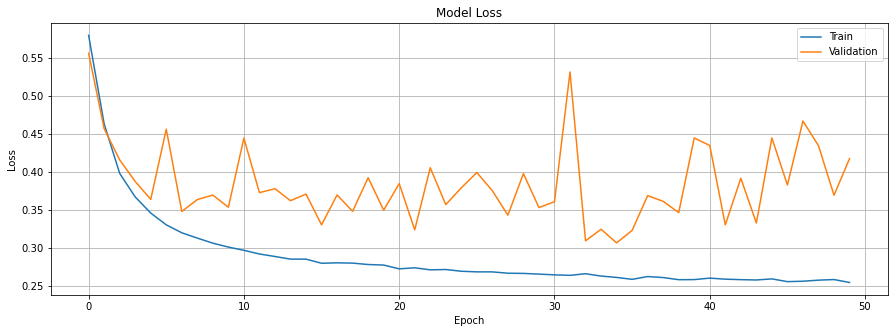

In [40]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

The validation loss topped the train loss early on which indicates overfitting but the validation accuracy was increasing too.

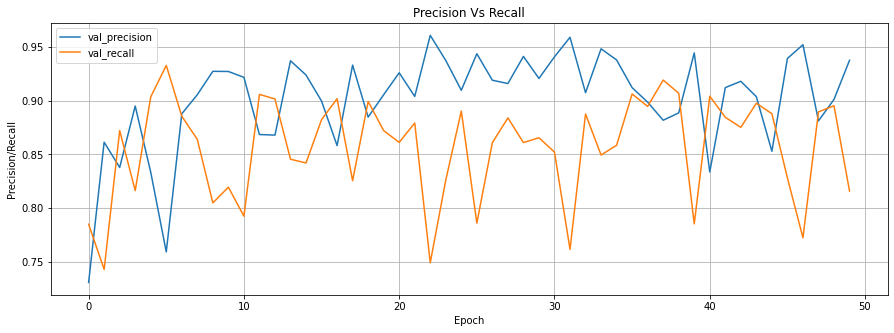

In [41]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

The val_precision and val_recall 'trends' were increasing but slowly.

In [42]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")

predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.9143
Test Accuracy: 0.9420
Test Precision: 0.1307
Test Recall: 0.7874
Test AUC: 0.9433
Test TP: 163
Test FP: 1084
Test TN: 18172
Test FN: 44


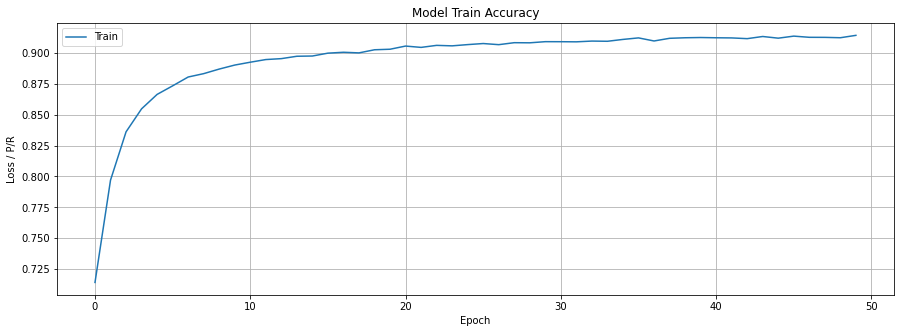

In [43]:
plt.figure(figsize=(15, 5))


plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Loss / P/R')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [44]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [49]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.19202692806720734
tp :  163.0
fp :  1084.0
tn :  18172.0
fn :  44.0
accuracy :  0.9420439004898071
precision :  0.13071371614933014
recall :  0.7874395847320557
auc :  0.9433130025863647

Non-Seizure Epochs Detected (True Negatives):  18172
Non-Seizure Epochs Incorrectly Detected (False Positives):  1084
Pre-Seizure Epochs Missed (False Negatives):  44
Pre-Seizure Epochs Detected (True Positives):  163
Total Pre-Seizure Epochs:  207


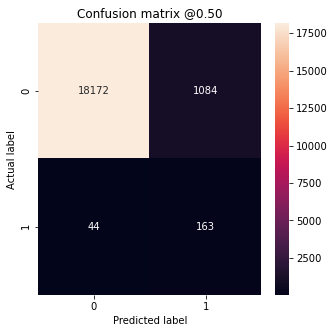

In [50]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cf_matrix = confusion_matrix(y_test, predictions)
# cf_matrix

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

This model was run for about 500 epochs on multiple runs, the results were among the best on the models that has been run later. The test accuracy is  0.94, precision :  0.13 and recall :  0.79. the relative number of false positive vs the true positive is what resulted in a low precision score on this model and on all other models on this project. This is inflated model weakness is due to the high target imbalance ~99:1 %. Therefore, precision  is not the right metric to look at. In addition to looking at accuracy and recall, we should consider looking at two more models, the false positive rate (FPR) and the false negative rate (FNR). These models are calculated as:
- FPR = FP / (FP+TN)
- FNR = FN / (FN+TP)

The FPR metric takes class 0 only on the calculation and the FNR takes class 1 only, so the two measures are not affected by the class imbalance.

For this model:

- FPR is 5.6%
- FNR is 21%

The simplest interpretation of this is the model make misclassification ~6% of the time on class 0 and 21% of the time on class 1.

------------------------

On this model, another technique is used where the Keras model `class_weight` parameter is used. This parameter is designed to tackle the class imbalance issue on neural networks by calculating the class imbalance and passing that to the model so it is considered while modeling. the data used should not be up-sampled as this is done during modeling.

Calculate class weights:

In [10]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg = df_seizure_w['target'].value_counts()[0]
pos = df_seizure_w['target'].value_counts()[1]
total = neg + pos
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 47.06


Model Ictal-2

In [11]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

weighted_model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
weighted_model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
weighted_model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 
# model.add(layers.BatchNormalization()) 

weighted_model.add(layers.Dense(20, activation="relu", kernel_regularizer=regularizer))
weighted_model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 
# model.add(layers.BatchNormalization())

weighted_model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer)) 
weighted_model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 
# model.add(layers.BatchNormalization())

# Declare the output layer
weighted_model.add(layers.Dense(1, activation="sigmoid"))

weighted_model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [12]:
# Fit the model
# history = model.fit(X_train_os_ss_PCA10, y_train_os, epochs=20)

# Train the model
weighted_history = weighted_model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=50, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os),
                    # The class weights go here
                    class_weight=class_weight) 

peep_me()

Epoch 1/50
3852/3852 [==============================] - 8s 2ms/step - loss: 1.5216 - tp: 61576.0000 - fp: 60363.0000 - tn: 1254.0000 - fn: 41.0000 - accuracy: 0.5098 - precision: 0.5050 - recall: 0.9993 - auc: 0.6720 - val_loss: 1.8917 - val_tp: 15338.0000 - val_fp: 14473.0000 - val_tn: 932.0000 - val_fn: 67.0000 - val_accuracy: 0.5281 - val_precision: 0.5145 - val_recall: 0.9957 - val_auc: 0.7972
Epoch 2/50
3852/3852 [==============================] - 7s 2ms/step - loss: 1.2006 - tp: 61604.0000 - fp: 57028.0000 - tn: 4589.0000 - fn: 13.0000 - accuracy: 0.5371 - precision: 0.5193 - recall: 0.9998 - auc: 0.8154 - val_loss: 1.7465 - val_tp: 15341.0000 - val_fp: 14029.0000 - val_tn: 1376.0000 - val_fn: 64.0000 - val_accuracy: 0.5426 - val_precision: 0.5223 - val_recall: 0.9958 - val_auc: 0.8433
Epoch 3/50
3852/3852 [==============================] - 8s 2ms/step - loss: 1.0803 - tp: 61601.0000 - fp: 54206.0000 - tn: 7411.0000 - fn: 16.0000 - accuracy: 0.5600 - precision: 0.5319 - recall: 0

3852/3852 [==============================] - 7s 2ms/step - loss: 0.7431 - tp: 61576.0000 - fp: 33987.0000 - tn: 27630.0000 - fn: 41.0000 - accuracy: 0.7239 - precision: 0.6443 - recall: 0.9993 - auc: 0.9294 - val_loss: 1.5766 - val_tp: 15270.0000 - val_fp: 9426.0000 - val_tn: 5979.0000 - val_fn: 135.0000 - val_accuracy: 0.6897 - val_precision: 0.6183 - val_recall: 0.9912 - val_auc: 0.8721
Epoch 42/50
3852/3852 [==============================] - 8s 2ms/step - loss: 0.7563 - tp: 61569.0000 - fp: 33782.0000 - tn: 27835.0000 - fn: 48.0000 - accuracy: 0.7255 - precision: 0.6457 - recall: 0.9992 - auc: 0.9306 - val_loss: 1.1493 - val_tp: 15204.0000 - val_fp: 8233.0000 - val_tn: 7172.0000 - val_fn: 201.0000 - val_accuracy: 0.7263 - val_precision: 0.6487 - val_recall: 0.9870 - val_auc: 0.9329
Epoch 43/50
3852/3852 [==============================] - 7s 2ms/step - loss: 0.7311 - tp: 61586.0000 - fp: 33322.0000 - tn: 28295.0000 - fn: 31.0000 - accuracy: 0.7294 - precision: 0.6489 - recall: 0.9995

In [13]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    plt.subplots(2,2, figsize=(12,12))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.5,1])
        else:
            plt.ylim([0,1])

    plt.legend()

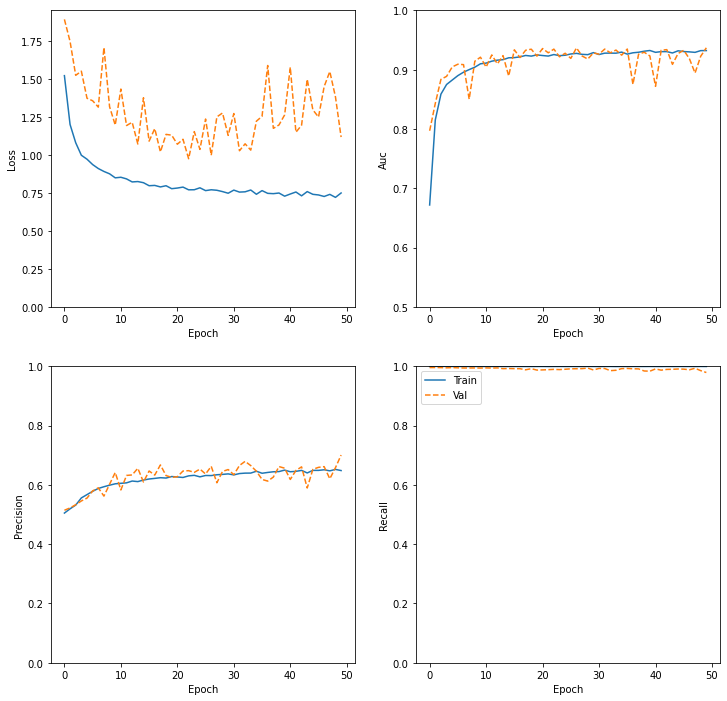

In [14]:
plot_metrics(weighted_history)

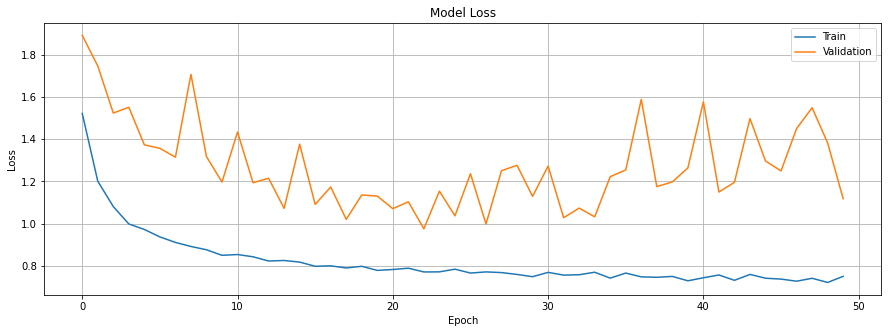

In [15]:
plt.figure(figsize=(15, 5))


plt.plot(weighted_history.history['loss'])
plt.plot(weighted_history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

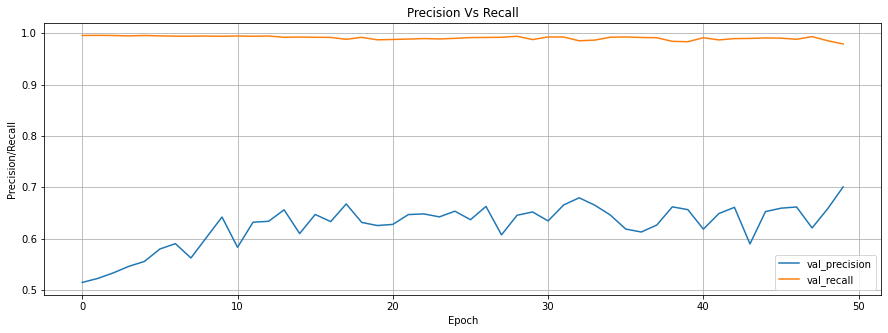

In [16]:
plt.figure(figsize=(15, 5))

plt.plot(weighted_history.history['val_precision'])
plt.plot(weighted_history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

In [19]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
weighted_train_accuracy = weighted_history.history["accuracy"][-1]
weighted_result = weighted_model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {weighted_train_accuracy:.4f}")
print(f"Test Accuracy: {weighted_result[5]:.4f}")
print(f"Test Precision: {weighted_result[6]:.4f}")
print(f"Test Recall: {weighted_result[7]:.4f}")
print(f"Test AUC: {weighted_result[8]:.4f}")
print(f"Test TP: {weighted_result[1]:.0f}")
print(f"Test FP: {weighted_result[2]:.0f}")
print(f"Test TN: {weighted_result[3]:.0f}")
print(f"Test FN: {weighted_result[4]:.0f}")

predictions = weighted_model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.7286
Test Accuracy: 0.5857
Test Precision: 0.0240
Test Recall: 0.9565
Test AUC: 0.9108
Test TP: 198
Test FP: 8054
Test TN: 11202
Test FN: 9


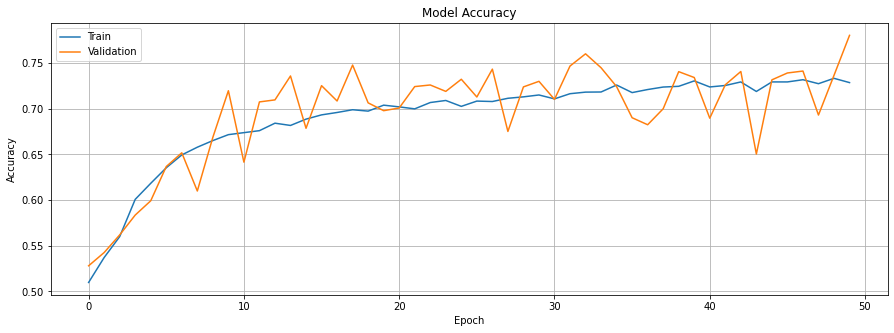

In [30]:
plt.figure(figsize=(15, 5))

plt.plot(weighted_history.history["accuracy"])
plt.plot(weighted_history.history["val_accuracy"])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [21]:
weighted_train_predictions_baseline = weighted_model.predict(X_train_os_ss_PCA10)
weighted_test_predictions_baseline = weighted_model.predict(X_test_ss_PCA10)

In [28]:
def plot_cm(labels, predictions, p=0.98):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  1.5157700777053833
tp :  198.0
fp :  8054.0
tn :  11202.0
fn :  9.0
accuracy :  0.5857267379760742
precision :  0.02399418316781521
recall :  0.95652174949646
auc :  0.9107974767684937

Non-Seizure Epochs Detected (True Negatives):  16404
Non-Seizure Epochs Incorrectly Detected (False Positives):  2852
Pre-Seizure Epochs Missed (False Negatives):  35
Pre-Seizure Epochs Detected (True Positives):  172
Total Pre-Seizure Epochs:  207


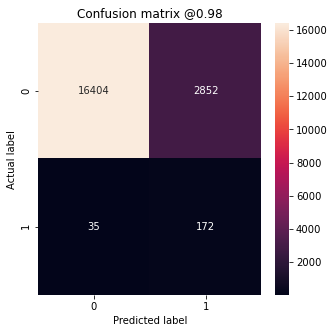

In [29]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cf_matrix = confusion_matrix(y_test, predictions)
# cf_matrix

weighted_baseline_results = weighted_model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, weighted_test_predictions_baseline)

The model was run for 50 epochs until the val loss started to increase exponentially. The model resulted in very low accuracy and precision scores. To increase the True positive value, the p has to be set very high @0.98 to result in acceptable true positives. This indicates a saturation in the model boundaries and does not suggest the model is stable.
For this model:

- FPR is 14.8% @0.98 p-threshold
- FNR is 16.7%  @0.98 p-threshold

--------------------------------

In the following model, the Dense network structure and number of neurons are increased. two more hidden layers are added and the number of neurons on each layer is doubled.

Model Ictal-3b - pickled on 050421.

In [11]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0.  

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer)) 
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0.

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 10% of the nodes to 0. 

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

epochs=20

In [12]:
# Fit the model
# Cell 24

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=20, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))

peep_me()

Epoch 1/20
3852/3852 [==============================] - 10s 3ms/step - loss: 0.5945 - tp: 42308.0000 - fp: 11609.0000 - tn: 50008.0000 - fn: 19309.0000 - accuracy: 0.7491 - precision: 0.7847 - recall: 0.6866 - auc: 0.8418 - val_loss: 0.5180 - val_tp: 13356.0000 - val_fp: 3876.0000 - val_tn: 11529.0000 - val_fn: 2049.0000 - val_accuracy: 0.8077 - val_precision: 0.7751 - val_recall: 0.8670 - val_auc: 0.8950
Epoch 2/20
3852/3852 [==============================] - 10s 3ms/step - loss: 0.3909 - tp: 52258.0000 - fp: 9092.0000 - tn: 52525.0000 - fn: 9359.0000 - accuracy: 0.8503 - precision: 0.8518 - recall: 0.8481 - auc: 0.9327 - val_loss: 0.4051 - val_tp: 13469.0000 - val_fp: 2074.0000 - val_tn: 13331.0000 - val_fn: 1936.0000 - val_accuracy: 0.8698 - val_precision: 0.8666 - val_recall: 0.8743 - val_auc: 0.9392
Epoch 3/20
3852/3852 [==============================] - 10s 3ms/step - loss: 0.3395 - tp: 54436.0000 - fp: 7620.0000 - tn: 53997.0000 - fn: 7181.0000 - accuracy: 0.8799 - precision: 0.

Save job as pickle 050421

In [35]:
# Save model
model.save('data/joblib/keras/detect_ictal_3b')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: data/joblib/keras/detect_ictal_3b\assets


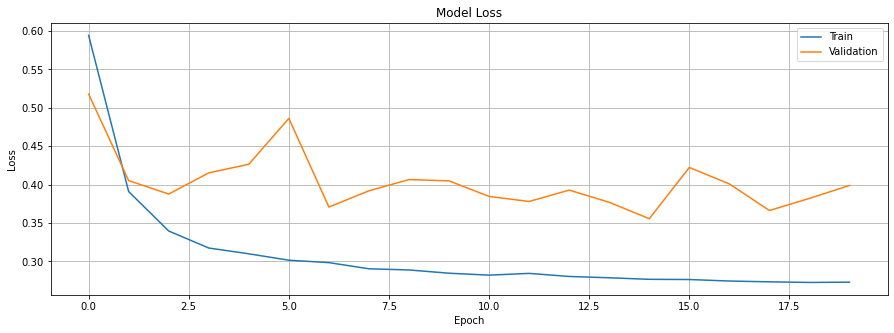

In [13]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

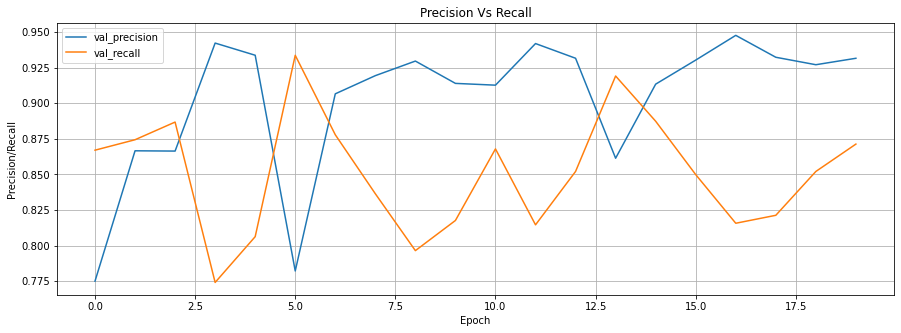

In [14]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

In [15]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")

predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.9173
Test Accuracy: 0.9354
Test Precision: 0.1211
Test Recall: 0.8116
Test AUC: 0.9524
Test TP: 168
Test FP: 1219
Test TN: 18037
Test FN: 39


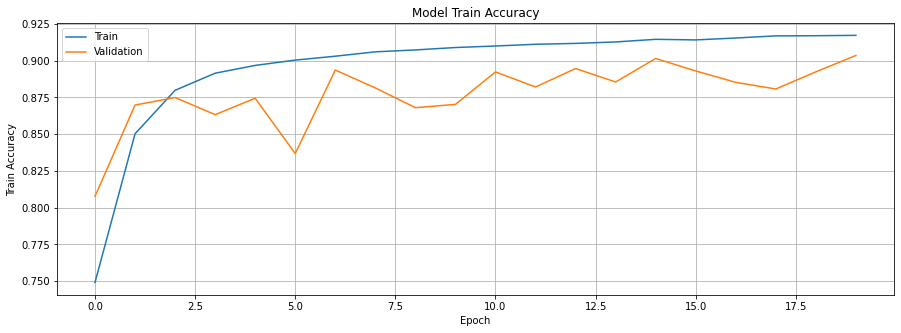

In [16]:
plt.figure(figsize=(15, 5))


plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [17]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [33]:
def plot_cm(labels, predictions, p=0.3):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.2303723692893982
tp :  168.0
fp :  1219.0
tn :  18037.0
fn :  39.0
accuracy :  0.9353645443916321
precision :  0.12112472951412201
recall :  0.8115941882133484
auc :  0.9523549675941467

Non-Seizure Epochs Detected (True Negatives):  17398
Non-Seizure Epochs Incorrectly Detected (False Positives):  1858
Pre-Seizure Epochs Missed (False Negatives):  29
Pre-Seizure Epochs Detected (True Positives):  178
Total Pre-Seizure Epochs:  207


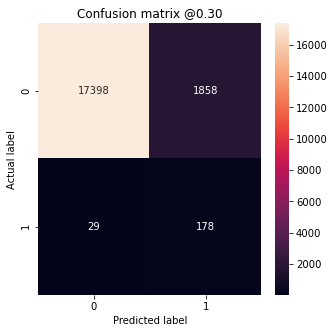

In [34]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cf_matrix = confusion_matrix(y_test, predictions)
# cf_matrix

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

The model was run for 20 epochs until the val accuracy and started to plateau. This model gave very good results. Accuracy of 0.94, precision of 0.12, and recall of 0.81, additionally for this model:

- FPR is 9.6% @0.3 p-threshold
- FNR is 14%  @0.3 p-threshold

This model so far strikes the best balance between the evaluation metrics.

-------------------------------------

On the next one, the structure was changed this time by removing the dropout layers form the model, it is expected that model will overfit.

Model Ictal-4

In [31]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer))
# model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
# model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer)) 
# model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 

model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizer))
# model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 

model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
# model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [32]:
# Fit the model
# Cell 25

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=100, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))

# # Save model as pickle
# import joblib
# nn_model_file = 'data/joblib/nn_model_22.joblib'
# joblib.dump(model, nn_model_file)

peep_me()

Epoch 1/100
3852/3852 [==============================] - 7s 2ms/step - loss: 0.5019 - tp: 47781.0000 - fp: 9635.0000 - tn: 51982.0000 - fn: 13836.0000 - accuracy: 0.8095 - precision: 0.8322 - recall: 0.7755 - auc: 0.9022 - val_loss: 0.5198 - val_tp: 12564.0000 - val_fp: 2389.0000 - val_tn: 13016.0000 - val_fn: 2841.0000 - val_accuracy: 0.8302 - val_precision: 0.8402 - val_recall: 0.8156 - val_auc: 0.9040
Epoch 2/100
3852/3852 [==============================] - 6s 2ms/step - loss: 0.3334 - tp: 54953.0000 - fp: 6864.0000 - tn: 54753.0000 - fn: 6664.0000 - accuracy: 0.8902 - precision: 0.8890 - recall: 0.8918 - auc: 0.9601 - val_loss: 0.6084 - val_tp: 9273.0000 - val_fp: 330.0000 - val_tn: 15075.0000 - val_fn: 6132.0000 - val_accuracy: 0.7903 - val_precision: 0.9656 - val_recall: 0.6019 - val_auc: 0.9480
Epoch 3/100
3852/3852 [==============================] - 9s 2ms/step - loss: 0.2872 - tp: 56339.0000 - fp: 5707.0000 - tn: 55910.0000 - fn: 5278.0000 - accuracy: 0.9109 - precision: 0.908

3852/3852 [==============================] - 11s 3ms/step - loss: 0.1730 - tp: 59444.0000 - fp: 3061.0000 - tn: 58556.0000 - fn: 2173.0000 - accuracy: 0.9575 - precision: 0.9510 - recall: 0.9647 - auc: 0.9918 - val_loss: 0.5505 - val_tp: 12355.0000 - val_fp: 564.0000 - val_tn: 14841.0000 - val_fn: 3050.0000 - val_accuracy: 0.8827 - val_precision: 0.9563 - val_recall: 0.8020 - val_auc: 0.9448
Epoch 42/100
3852/3852 [==============================] - 8s 2ms/step - loss: 0.1734 - tp: 59415.0000 - fp: 3106.0000 - tn: 58511.0000 - fn: 2202.0000 - accuracy: 0.9569 - precision: 0.9503 - recall: 0.9643 - auc: 0.9917 - val_loss: 0.5299 - val_tp: 13043.0000 - val_fp: 1178.0000 - val_tn: 14227.0000 - val_fn: 2362.0000 - val_accuracy: 0.8851 - val_precision: 0.9172 - val_recall: 0.8467 - val_auc: 0.9408
Epoch 43/100
3852/3852 [==============================] - 8s 2ms/step - loss: 0.1745 - tp: 59398.0000 - fp: 3120.0000 - tn: 58497.0000 - fn: 2219.0000 - accuracy: 0.9567 - precision: 0.9501 - recal

3852/3852 [==============================] - 7s 2ms/step - loss: 0.1643 - tp: 59526.0000 - fp: 2911.0000 - tn: 58706.0000 - fn: 2091.0000 - accuracy: 0.9594 - precision: 0.9534 - recall: 0.9661 - auc: 0.9927 - val_loss: 0.4873 - val_tp: 13398.0000 - val_fp: 898.0000 - val_tn: 14507.0000 - val_fn: 2007.0000 - val_accuracy: 0.9057 - val_precision: 0.9372 - val_recall: 0.8697 - val_auc: 0.9566
Epoch 82/100
3852/3852 [==============================] - 7s 2ms/step - loss: 0.1646 - tp: 59516.0000 - fp: 2909.0000 - tn: 58708.0000 - fn: 2101.0000 - accuracy: 0.9593 - precision: 0.9534 - recall: 0.9659 - auc: 0.9926 - val_loss: 0.4242 - val_tp: 12937.0000 - val_fp: 600.0000 - val_tn: 14805.0000 - val_fn: 2468.0000 - val_accuracy: 0.9004 - val_precision: 0.9557 - val_recall: 0.8398 - val_auc: 0.9611
Epoch 83/100
3852/3852 [==============================] - 7s 2ms/step - loss: 0.1629 - tp: 59555.0000 - fp: 2871.0000 - tn: 58746.0000 - fn: 2062.0000 - accuracy: 0.9600 - precision: 0.9540 - recall:

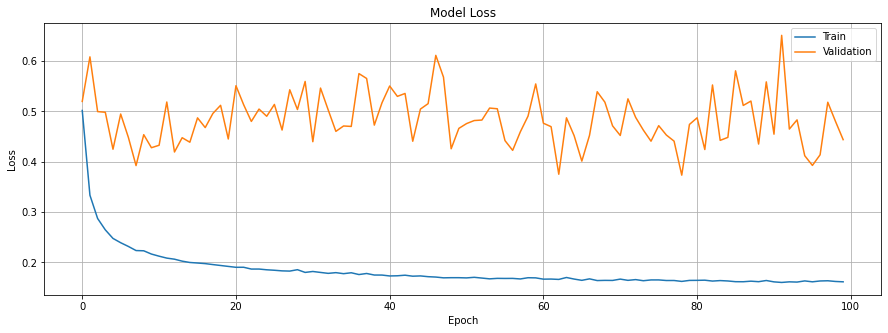

In [33]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

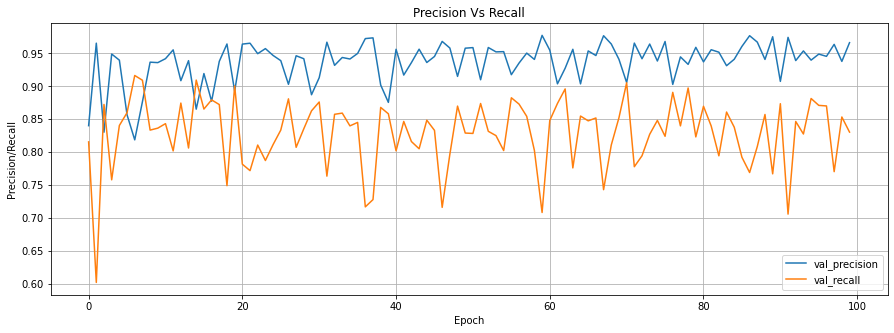

In [35]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

In [36]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")

predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.9606
Test Accuracy: 0.9687
Test Precision: 0.2134
Test Recall: 0.7246
Test AUC: 0.9270
Test TP: 150
Test FP: 553
Test TN: 18703
Test FN: 57


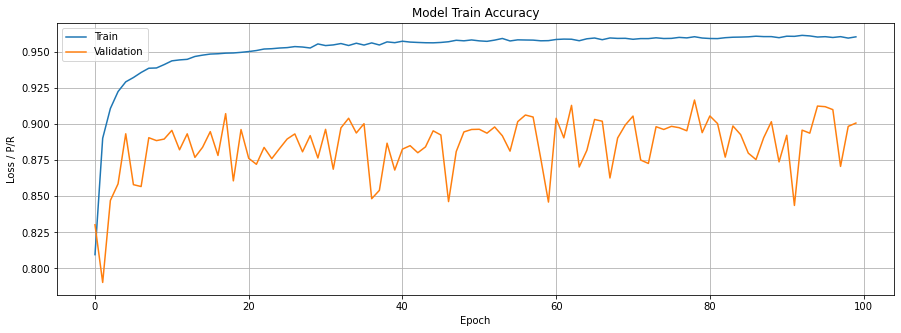

In [38]:
plt.figure(figsize=(15, 5))


plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Loss / P/R')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [39]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [54]:
def plot_cm(labels, predictions, p=0.05):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.15037624537944794
tp :  150.0
fp :  553.0
tn :  18703.0
fn :  57.0
accuracy :  0.9686585068702698
precision :  0.21337126195430756
recall :  0.7246376872062683
auc :  0.9269610643386841

Non-Seizure Epochs Detected (True Negatives):  16939
Non-Seizure Epochs Incorrectly Detected (False Positives):  2317
Pre-Seizure Epochs Missed (False Negatives):  31
Pre-Seizure Epochs Detected (True Positives):  176
Total Pre-Seizure Epochs:  207


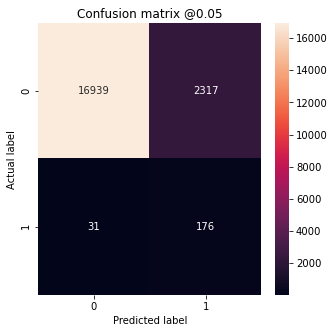

In [55]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cf_matrix = confusion_matrix(y_test, predictions)
# cf_matrix

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

The same model was run again but without drop out his time for 100 epochs, the model overfitted very early on, the train false positives dropped dramatically and the val accuracy started to decrease. surprisingly the model resulted in high accuracy and precision scores and good recall.
- accuracy :  0.96
- precision :  0.21
- recall :  0.72

additionally for this model:

- FPR is 12% @0.05 p-threshold
- FNR is 14.9%  @0.05 p-threshold

---------------------------

Also the minmax scaler was used to scale the data before fitting few models, the result however were not better than those obtained by using the standard scaler. The code was omitted.

-----------------------------------

On this model, the activation model on the hidden function is changed to Hyperbolic Tangent (Tanh) instead of Relu.

Model Ictal-6

In [56]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(80, activation="tanh", kernel_regularizer=regularizer))
# model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 
# model.add(layers.BatchNormalization()) 

model.add(layers.Dense(40, activation="tanh", kernel_regularizer=regularizer))
# model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 

model.add(layers.Dense(80, activation="tanh", kernel_regularizer=regularizer)) 
# model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 

model.add(layers.Dense(80, activation="tanh", kernel_regularizer=regularizer))
# model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 

model.add(layers.Dense(40, activation="tanh", kernel_regularizer=regularizer))
# model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [57]:
# Fit the model
# Cell 27

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=100, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))

peep_me()

Epoch 1/100
3852/3852 [==============================] - 8s 2ms/step - loss: 0.5398 - tp: 45270.0000 - fp: 11271.0000 - tn: 50346.0000 - fn: 16347.0000 - accuracy: 0.7759 - precision: 0.8007 - recall: 0.7347 - auc: 0.8675 - val_loss: 0.5354 - val_tp: 9935.0000 - val_fp: 1297.0000 - val_tn: 14108.0000 - val_fn: 5470.0000 - val_accuracy: 0.7804 - val_precision: 0.8845 - val_recall: 0.6449 - val_auc: 0.8784
Epoch 2/100
3852/3852 [==============================] - 7s 2ms/step - loss: 0.4248 - tp: 49044.0000 - fp: 9012.0000 - tn: 52605.0000 - fn: 12573.0000 - accuracy: 0.8248 - precision: 0.8448 - recall: 0.7959 - auc: 0.9133 - val_loss: 0.4770 - val_tp: 11542.0000 - val_fp: 1868.0000 - val_tn: 13537.0000 - val_fn: 3863.0000 - val_accuracy: 0.8140 - val_precision: 0.8607 - val_recall: 0.7492 - val_auc: 0.8992
Epoch 3/100
3852/3852 [==============================] - 7s 2ms/step - loss: 0.3951 - tp: 50563.0000 - fp: 8407.0000 - tn: 53210.0000 - fn: 11054.0000 - accuracy: 0.8421 - precision: 0

3852/3852 [==============================] - 15s 4ms/step - loss: 0.2843 - tp: 56465.0000 - fp: 5621.0000 - tn: 55996.0000 - fn: 5152.0000 - accuracy: 0.9126 - precision: 0.9095 - recall: 0.9164 - auc: 0.9736 - val_loss: 0.4923 - val_tp: 12894.0000 - val_fp: 1638.0000 - val_tn: 13767.0000 - val_fn: 2511.0000 - val_accuracy: 0.8653 - val_precision: 0.8873 - val_recall: 0.8370 - val_auc: 0.9288
Epoch 42/100
3852/3852 [==============================] - 15s 4ms/step - loss: 0.2843 - tp: 56439.0000 - fp: 5686.0000 - tn: 55931.0000 - fn: 5178.0000 - accuracy: 0.9118 - precision: 0.9085 - recall: 0.9160 - auc: 0.9736 - val_loss: 0.5059 - val_tp: 13152.0000 - val_fp: 1560.0000 - val_tn: 13845.0000 - val_fn: 2253.0000 - val_accuracy: 0.8762 - val_precision: 0.8940 - val_recall: 0.8537 - val_auc: 0.9292
Epoch 43/100
3852/3852 [==============================] - 15s 4ms/step - loss: 0.2831 - tp: 56539.0000 - fp: 5621.0000 - tn: 55996.0000 - fn: 5078.0000 - accuracy: 0.9132 - precision: 0.9096 - re

3852/3852 [==============================] - 15s 4ms/step - loss: 0.2684 - tp: 57027.0000 - fp: 5181.0000 - tn: 56436.0000 - fn: 4590.0000 - accuracy: 0.9207 - precision: 0.9167 - recall: 0.9255 - auc: 0.9779 - val_loss: 0.4514 - val_tp: 12940.0000 - val_fp: 1138.0000 - val_tn: 14267.0000 - val_fn: 2465.0000 - val_accuracy: 0.8831 - val_precision: 0.9192 - val_recall: 0.8400 - val_auc: 0.9488
Epoch 82/100
3852/3852 [==============================] - 15s 4ms/step - loss: 0.2671 - tp: 56997.0000 - fp: 5177.0000 - tn: 56440.0000 - fn: 4620.0000 - accuracy: 0.9205 - precision: 0.9167 - recall: 0.9250 - auc: 0.9782 - val_loss: 0.5455 - val_tp: 11846.0000 - val_fp: 651.0000 - val_tn: 14754.0000 - val_fn: 3559.0000 - val_accuracy: 0.8634 - val_precision: 0.9479 - val_recall: 0.7690 - val_auc: 0.9403
Epoch 83/100
3852/3852 [==============================] - 15s 4ms/step - loss: 0.2677 - tp: 57040.0000 - fp: 5225.0000 - tn: 56392.0000 - fn: 4577.0000 - accuracy: 0.9205 - precision: 0.9161 - rec

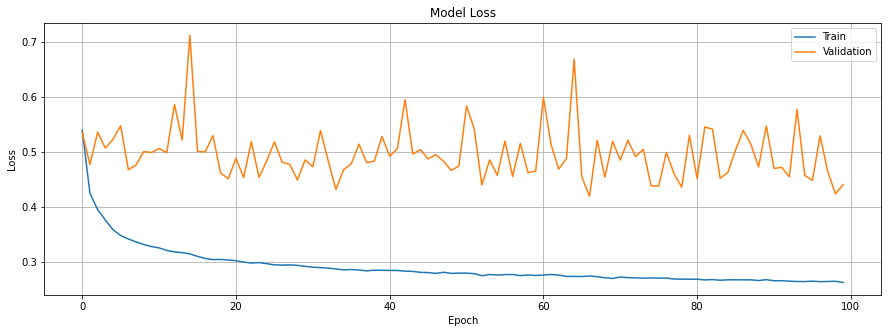

In [58]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

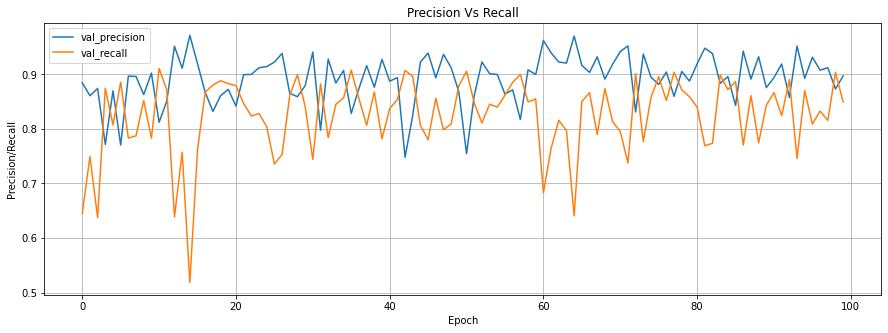

In [59]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

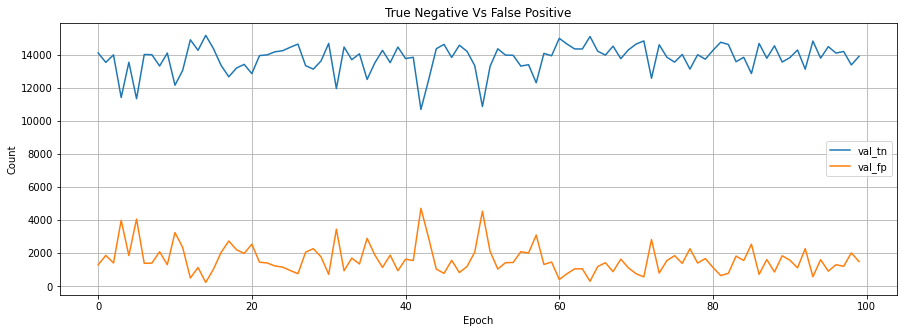

In [60]:
plt.figure(figsize=(15, 5))


plt.plot(history.history['val_tn'])
plt.plot(history.history['val_fp'])

plt.title('True Negative Vs False Positive')
plt.ylabel('Count')
plt.xlabel('Epoch')
plt.legend(['val_tn', 'val_fp'])
plt.grid()

plt.show()

In [61]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")

predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.9228
Test Accuracy: 0.9017
Test Precision: 0.0790
Test Recall: 0.7729
Test AUC: 0.9144
Test TP: 160
Test FP: 1866
Test TN: 17390
Test FN: 47


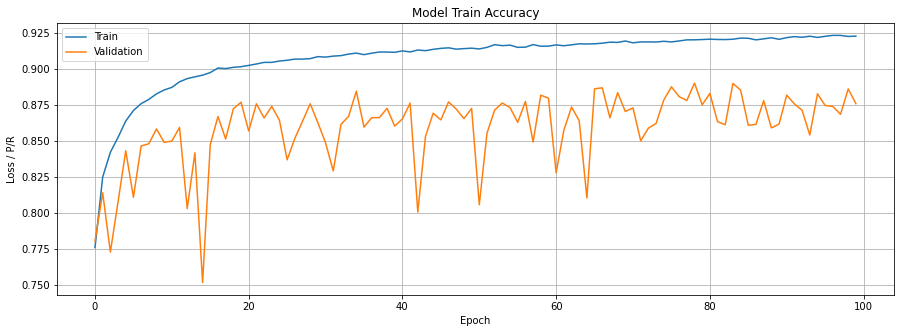

In [62]:
plt.figure(figsize=(15, 5))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title('Model Train Accuracy')
plt.ylabel('Loss / P/R')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [63]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [68]:
def plot_cm(labels, predictions, p=0.2):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.3187170624732971
tp :  160.0
fp :  1866.0
tn :  17390.0
fn :  47.0
accuracy :  0.9017109274864197
precision :  0.07897334545850754
recall :  0.772946834564209
auc :  0.9144484996795654

Non-Seizure Epochs Detected (True Negatives):  16039
Non-Seizure Epochs Incorrectly Detected (False Positives):  3217
Pre-Seizure Epochs Missed (False Negatives):  28
Pre-Seizure Epochs Detected (True Positives):  179
Total Pre-Seizure Epochs:  207


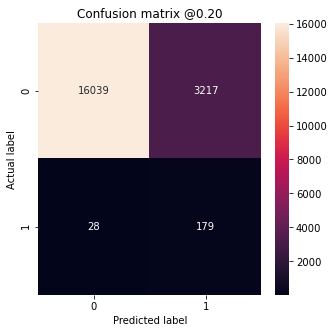

In [69]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cf_matrix = confusion_matrix(y_test, predictions)
# cf_matrix

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

The Tanh model was run for about 100 epochs but the results were not as good.

--------------------------------------------------

Now let us try the SELU activation function instead of Tanh and Relu.

Model Ictal-7

In [72]:
# Create a new sequential model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(80, activation="selu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(40, activation="selu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(80, activation="selu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(80, activation="selu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

model.add(layers.Dense(40, activation="selu", kernel_regularizer=regularizer, kernel_initializer='lecun_normal'))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [75]:
# Fit the model
# Cell 28

# Train the model
history = model.fit(X_train_os_ss_PCA10, 
                    y_train_os, 
                    epochs=50, 
                    verbose=1, 
                    # Pass in a validation data set to test each epoch.
                    validation_data=(X_val_os_ss_PCA10, y_val_os))

peep_me()

Epoch 1/50
3852/3852 [==============================] - 7s 2ms/step - loss: 0.2165 - tp: 58727.0000 - fp: 3696.0000 - tn: 57921.0000 - fn: 2890.0000 - accuracy: 0.9466 - precision: 0.9408 - recall: 0.9531 - auc: 0.9885 - val_loss: 0.4962 - val_tp: 12579.0000 - val_fp: 973.0000 - val_tn: 14432.0000 - val_fn: 2826.0000 - val_accuracy: 0.8767 - val_precision: 0.9282 - val_recall: 0.8166 - val_auc: 0.9572
Epoch 2/50
3852/3852 [==============================] - 8s 2ms/step - loss: 0.2176 - tp: 58724.0000 - fp: 3697.0000 - tn: 57920.0000 - fn: 2893.0000 - accuracy: 0.9465 - precision: 0.9408 - recall: 0.9530 - auc: 0.9883 - val_loss: 0.5583 - val_tp: 12491.0000 - val_fp: 871.0000 - val_tn: 14534.0000 - val_fn: 2914.0000 - val_accuracy: 0.8772 - val_precision: 0.9348 - val_recall: 0.8108 - val_auc: 0.9495
Epoch 3/50
3852/3852 [==============================] - 9s 2ms/step - loss: 0.2171 - tp: 58759.0000 - fp: 3711.0000 - tn: 57906.0000 - fn: 2858.0000 - accuracy: 0.9467 - precision: 0.9406 - 

3852/3852 [==============================] - 8s 2ms/step - loss: 0.2100 - tp: 58908.0000 - fp: 3541.0000 - tn: 58076.0000 - fn: 2709.0000 - accuracy: 0.9493 - precision: 0.9433 - recall: 0.9560 - auc: 0.9894 - val_loss: 0.6253 - val_tp: 13500.0000 - val_fp: 2489.0000 - val_tn: 12916.0000 - val_fn: 1905.0000 - val_accuracy: 0.8574 - val_precision: 0.8443 - val_recall: 0.8763 - val_auc: 0.9288
Epoch 42/50
3852/3852 [==============================] - 9s 2ms/step - loss: 0.2112 - tp: 58883.0000 - fp: 3592.0000 - tn: 58025.0000 - fn: 2734.0000 - accuracy: 0.9487 - precision: 0.9425 - recall: 0.9556 - auc: 0.9891 - val_loss: 0.5626 - val_tp: 12390.0000 - val_fp: 795.0000 - val_tn: 14610.0000 - val_fn: 3015.0000 - val_accuracy: 0.8763 - val_precision: 0.9397 - val_recall: 0.8043 - val_auc: 0.9462
Epoch 43/50
3852/3852 [==============================] - 8s 2ms/step - loss: 0.2108 - tp: 58878.0000 - fp: 3590.0000 - tn: 58027.0000 - fn: 2739.0000 - accuracy: 0.9486 - precision: 0.9425 - recall: 

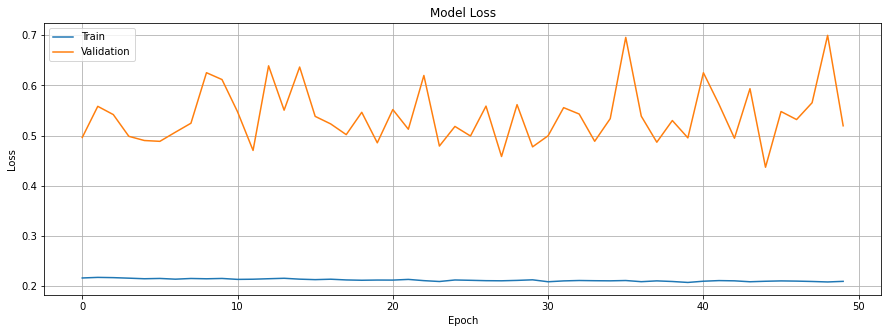

In [76]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

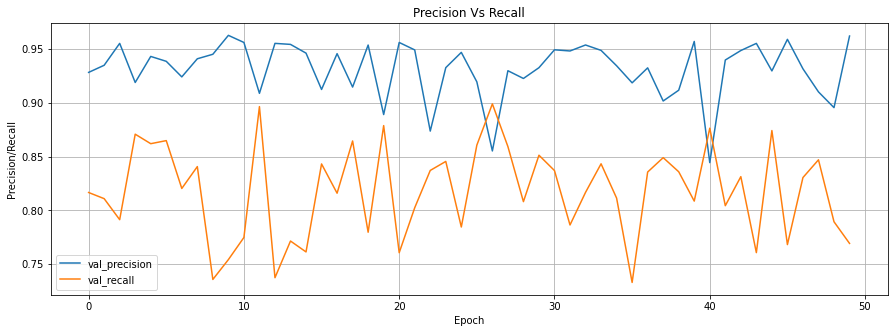

In [77]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.title('Precision Vs Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['val_precision', 'val_recall'])
plt.grid()

plt.show()

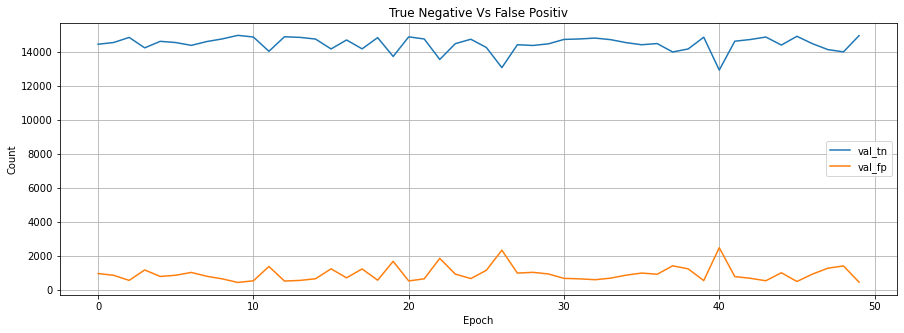

In [78]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['val_tn'])
plt.plot(history.history['val_fp'])

plt.title('True Negative Vs False Positiv')
plt.ylabel('Count')
plt.xlabel('Epoch')
plt.legend(['val_tn', 'val_fp'])
plt.grid()

plt.show()

In [79]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(X_test_ss_PCA10,y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")

predictions = model.predict(X_test_ss_PCA10)
# peep_me()

Train Accuracy: 0.9494
Test Accuracy: 0.9667
Test Precision: 0.2048
Test Recall: 0.7391
Test AUC: 0.9510
Test TP: 153
Test FP: 594
Test TN: 18662
Test FN: 54


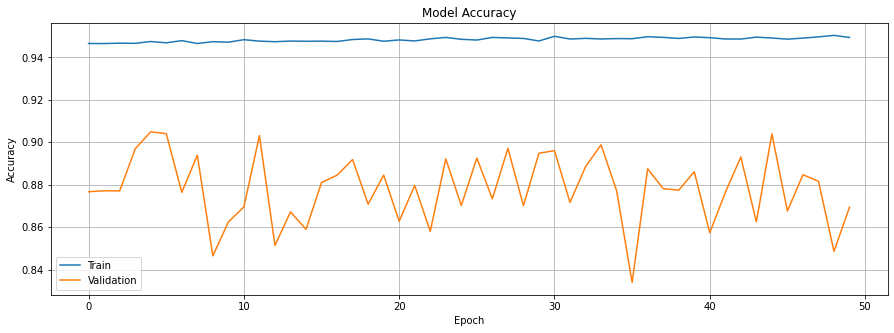

In [80]:
plt.figure(figsize=(15, 5))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.show()

In [81]:
train_predictions_baseline = model.predict(X_train_os_ss_PCA10)
test_predictions_baseline = model.predict(X_test_ss_PCA10)

In [90]:
def plot_cm(labels, predictions, p=0.1):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Seizure Epochs Detected (True Negatives): ', cm[0][0])
    print('Non-Seizure Epochs Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pre-Seizure Epochs Missed (False Negatives): ', cm[1][0])
    print('Pre-Seizure Epochs Detected (True Positives): ', cm[1][1])
    print('Total Pre-Seizure Epochs: ', np.sum(cm[1]))

loss :  0.1788727045059204
tp :  153.0
fp :  594.0
tn :  18662.0
fn :  54.0
accuracy :  0.9667060375213623
precision :  0.20481927692890167
recall :  0.739130437374115
auc :  0.9510012865066528

Non-Seizure Epochs Detected (True Negatives):  17194
Non-Seizure Epochs Incorrectly Detected (False Positives):  2062
Pre-Seizure Epochs Missed (False Negatives):  21
Pre-Seizure Epochs Detected (True Positives):  186
Total Pre-Seizure Epochs:  207


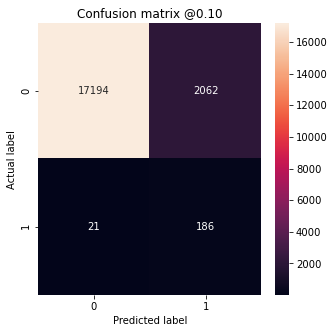

In [91]:
# # create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cf_matrix = confusion_matrix(y_test, predictions)
# cf_matrix

baseline_results = model.evaluate(X_test_ss_PCA10, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

The Selu activation function model was run at 125 epochs. This model has got the best accuracy score along with the highest or second-highest precision. the model recall is relatively good as well at 0.74. Additionally the model has scored the lowest combination of FPR  and FNR at ~10%.  
accuracy :  0.97
precision :  0.20
recall :  0.74

additionally for this model:

- FPR is 10.7% @0.1 p-threshold
- FNR is 10.1% @0.1 p-threshold

----------------------------------

# Summary

The optimization has been done manually for this network. The regularization was changed from 0.001 to 0.01 and 0.0001 but it was either inducing overfitting or causing an increase in the false-positive after the first few epochs, the code of which was omitted from the notebook as the fitting was stopped early. 

The best four performing models resulted in the following metrics:    


| Model | Activation | Structure | Accuracy@0.5 | Precision@0.5 | Recall@0.5 | FPR%@ | FNR%@ | FNR/FPR@ p-Threshold | Training Epochs |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Ictal-1 | Relu | 3 layers (40,20, etc..) | 0.94 | 0.13 | 0.79 | 5.6 | 21 | 0.3 | 500 |
| Ictal-3b | Relu | 5 layers (80,40, etc..) | 0.94 | 0.12 | 0.81 | 9.6 | 14 | 0.3 | 20 |
| Ictal-4 | Relu | No dropout layers | 0.97 | 0.21 | 0.72 | 12 | 14.9 | 0.05 | 100 |
| Ictal-7 | Selu | 5 layers (80,40, etc..) | 0.97 |  0.20  | 0.74 | 10.1 | 10.7 | 0.1 | 125 |

It can be debated which one is the best model among them all, all the models have the flexibility to control the FPR and FNR by controlling the p-threshold, therefore we should try to compare them based on their accuracy, precision, and recall at 0.5 threshold. 

The recall is the most important score on this problem. the reason is that lower false negatives mean lower seizure incidents and this is what we are after. More false positives are not good but in the worst case, the scenario will mean the patient will have to stop and stay safe for few minutes until the misclassification period passes away which is not as bad given the whole model will help them reduce uncertainty. That been said, reducing the false positive should be attempted as much as possible as well but it comes second in priority.

Since the first two models scored the highest on the recall, they are considered to be more efficient than the latter two. each one of the two has advantages and disadvantages, the first has high epochs but a simpler structure, the second comes with a more complex structure but a low number of epochs. 


The following are some takeaways from this optimization exercise:
- The selu model showed a better ability to minimize the false positives, which may result in better performance if trained longer.
- All the models showed a fast cross of the train and val losses but the point was to watch for the val accuracy increase in the meantime.
- High false positives are a problem on these models, this is mainly due to the class imbalance.
- Manual optimization although not the most efficient way facilitated a way to monitor the metrics while the models were fitting.

The next notebook `4_Modelling_Prediction` contains the optimization of the prediction problem models.